In [1]:
import os, h5py
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from tqdm import tqdm
import copy, math
import collections

from cremerl import utils, model_zoo, shuffle

import shuffle_test

#import gymnasium as gym

import logging

# Set the logging level to WARNING
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
expt_name = 'DeepSTARR'

# load data
data_path = '../../data/'
filepath = os.path.join(data_path, expt_name+'_data.h5')
data_module = utils.H5DataModule(filepath, batch_size=100, lower_case=False, transpose=False)


In [3]:
deepstarr2 = model_zoo.deepstarr(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr2, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = model_zoo.DeepSTARR(deepstarr2,
                                  criterion=loss,
                                  optimizer=optimizer_dict)

# load checkpoint for model with best validation performance
standard_cnn = utils.load_model_from_checkpoint(standard_cnn, 'DeepSTARR_standard.ckpt')

# evaluate best model
pred = utils.get_predictions(standard_cnn, data_module.x_test[np.newaxis,100], batch_size=100)

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
2023-08-16 10:10:44.805049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 10:10:45.327746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Predicting: 0it [00:00, ?it/s]

In [4]:
def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [5]:
def get_batch(x, tile_range, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        ori = x.copy()
        mut = x_mut.copy()
        
        ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)
        
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
        
        test_batch.append(ori)
        test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)


def get_batch_score(pred, trials):

    score = []
    score_sep = []
    for i in range(0, pred.shape[0], 2):
        # print(f"Viewing number {i}")
        score1 = pred[0] - pred[i]
        score2 = pred[i+1] - pred[1]
        score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
        score_sep.append((score1+score2).tolist())
        
    # print(score)
        
    final = np.sum(np.array(score), axis=0)/trials

    #max_ind = np.argmax(final)
    #block_ind = np.argmax(np.array(score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])
    total_score_sep = np.sum(np.array(score_sep), axis=0)/trials

    #print(np.max(score))
    return final

In [6]:
def extend_sequence(one_hot_sequence):
    A, L = one_hot_sequence.shape

    # Create an all-ones row
    ones_row = np.zeros(L)

    # Add the all-ones row to the original sequence
    new_sequence = np.vstack((one_hot_sequence, ones_row))

    return np.array(new_sequence, dtype='float32')

def taking_action(sequence_with_ones, tile_range):
    start_idx, end_idx = tile_range

    # Ensure the start_idx and end_idx are within valid bounds
    #if start_idx < 0 or start_idx >= sequence_with_ones.shape[1] or end_idx < 0 or end_idx >= sequence_with_ones.shape[1]:
    #    raise ValueError("Invalid tile range indices.")

    # Copy the input sequence to avoid modifying the original sequence
    modified_sequence = sequence_with_ones.copy()

    # Modify the last row within the specified tile range
    modified_sequence[-1, start_idx:end_idx] = 1

    return np.array(modified_sequence, dtype='float32')

In [7]:
def convert_elements(input_list):
    input_list = input_list.tolist()
    num_columns = 5  # Number of elements to process in each group

    # Calculate the number of elements needed to pad the list
    padding_length = num_columns - (len(input_list) % num_columns)
    last_value = input_list[-1]
    padded_list = input_list + [last_value] * padding_length

    # Convert the padded list to a NumPy array for efficient operations
    input_array = np.array(padded_list)
    reshaped_array = input_array.reshape(-1, num_columns)

    # Check if each row has the same value (all 0s or all 1s)
    row_all_zeros = np.all(reshaped_array == 0, axis=1)
    row_all_ones = np.all(reshaped_array == 1, axis=1)

    # Replace all 0s with 0 and all 1s with 1 in the result array
    output_array = np.where(row_all_zeros, 0, np.where(row_all_ones, 1, reshaped_array[:, 0]))

    # Flatten the result array to get the final output list
    output_list = output_array.flatten()

    return output_list

In [8]:
class SeqGame:
    def __init__(self, sequence, model_func):
        self.seq = sequence
        self.ori_seq = sequence.copy()
        self.tile_ranges = generate_tile_ranges(sequence.shape[1], 5, 5)
        self.levels = 20
        self.num_trials = 10
        self.action_size = 50
        
        self.prev_score = -float("inf")
        self.current_score = 0
        
        self.trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
        self.model = model_func
        
        if self.seq.shape[0]!=5:
            self.seq = extend_sequence(self.seq)
            self.ori_seq = extend_sequence(self.ori_seq)
        
    
    def get_initial_state(self):
        self.seq = self.ori_seq.copy()
        
        return self.seq
    
    
    def get_next_state(self, action, tile_ranges_done):
        self.prev_score = self.current_score
        # self.current_level += 1
        
        self.seq = taking_action(self.seq, self.tile_ranges[action])
        
        batch = get_batch(self.seq[:4, :], self.tile_ranges[action], tile_ranges_done, self.num_trials)
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred = np.concatenate(self.trainer.predict(self.model, dataloaders=dataloader))
        
        # self.current_score = np.tanh(1 * get_batch_score(pred, self.num_trials)) #ADDED TANH
        self.current_score = get_batch_score(pred, self.num_trials)
        
        return self.seq
    
    def get_valid_moves(self):
        return (convert_elements(self.seq[-1, :]) == 0).astype(np.uint8)
    
    def terminate(self, level, current_score, parent_score): #state
        # if self.current_level >= self.levels:
        #     return True
        # if self.current_score < self.prev_score:
        #     return True
        
        if level >= self.levels:
            return True
        if current_score < parent_score:
            return True
    
        return False
    
    def set_seq(self, seq):
        self.seq = seq
    
    def get_seq(self):
        return self.seq.copy()
    
    def get_score(self):
        return self.current_score

In [9]:
class Node:
    def __init__(self, action, state, done, reward, mcts, level, tile_ranges_done, parent=None):
        self.env = parent.env
        self.action = action
        
        self.is_expanded = False
        self.parent = parent
        self.children = {}
        
        self.action_space_size = self.env.action_size
        self.child_total_value = np.zeros(
            [self.action_space_size], dtype=np.float32
        ) # Q
        self.child_priors = np.zeros([self.action_space_size], dtype=np.float32) # P
        self.child_number_visits = np.zeros(
            [self.action_space_size], dtype=np.float32
        ) # N
        self.valid_actions = (convert_elements(state[-1, :]) == 0).astype(np.bool_) # uint8
        
        self.reward = reward
        self.done = done
        self.state = state
        self.level = level
        
        self.tile_ranges_done = tile_ranges_done
        
        self.mcts = mcts
    
    @property
    def number_visits(self):
        return self.parent.child_number_visits[self.action]
    
    @number_visits.setter
    def number_visits(self, value):
        self.parent.child_number_visits[self.action] = value
        
    @property
    def total_value(self):
        return self.parent.child_total_value[self.action]
    
    @total_value.setter
    def total_value(self, value):
        self.parent.child_total_value[self.action] = value
        
    def child_Q(self):
        return self.child_total_value / (1 + self.child_number_visits)
    
    def child_U(self):
        return (
            math.sqrt(self.number_visits)
            * self.child_priors
            / (1 + self.child_number_visits)
        )
    
    def best_action(self):
        child_score = self.child_Q() + self.mcts.c_puct * self.child_U()
        masked_child_score = child_score
        masked_child_score[~self.valid_actions] = -np.inf
        # masked_child_score = masked_child_score * self.valid_actions
        return np.argmax(masked_child_score)
    
    def select(self):
        current_node = self
        while current_node.is_expanded:
            best_action = current_node.best_action()
            current_node = current_node.get_child(best_action)
        return current_node
    
    def expand(self, child_priors):
        self.is_expanded = True
        self.child_priors = child_priors
        
    def set_state(self, state):
        self.state = state
        self.valid_actions = (convert_elements(state[-1, :]) == 0).astype(np.bool_) # uint8
    
    def get_child(self, action):
        if action not in self.children:

            self.env.set_seq(self.state.copy())
            next_state = self.env.get_next_state(action, self.tile_ranges_done)
            new_tile_ranges_done = copy.deepcopy(self.tile_ranges_done)
            new_tile_ranges_done.append(self.env.tile_ranges[action])
            # swap tile_ranges
            reward = self.env.get_score()
            terminated = self.env.terminate(self.level, reward, self.parent.reward)
            self.children[action] = Node(
                state=next_state, 
                action=action, 
                parent=self, 
                reward=reward,
                done=terminated,
                mcts=self.mcts, 
                level=self.level+1, 
                tile_ranges_done=new_tile_ranges_done
            )
        return self.children[action]
    
    def backup(self, value):
        current = self
        while current.parent is not None:
            current.number_visits += 1
            current.total_value += value
            current = current.parent

class RootParentNode:
    def __init__(self, env):
        self.parent = None
        self.child_total_value = collections.defaultdict(float)
        self.child_number_visits = collections.defaultdict(float)
        self.env = env
        self.reward = -np.inf

class MCTS_P:
    def __init__(self, model, mcts_param):
        self.model = model
        self.temperature = mcts_param["temperature"]
        self.dir_epsilon = mcts_param["dirichlet_epsilon"]
        self.dir_noise = mcts_param["dirichlet_noise"]
        self.num_sims = mcts_param["num_simulations"]
        self.exploit = mcts_param["argmax_tree_policy"]
        self.add_dirichlet_noise = mcts_param["add_dirichlet_noise"]
        self.c_puct = mcts_param["puct_coefficient"]
    
    def compute_action(self, buffers):
        for _ in range(self.num_sims):
            for buffer in buffers:
                leaf = buffer.root.select()
                if leaf.done:
                    buffer_value = leaf.reward
                    leaf.backup(buffer_value)
                else:
                    buffer.node = leaf
        
            expandable_buffers = [mappingIdx for mappingIdx in range(len(buffers)) if buffers[mappingIdx].node.done is False]
            
            
            if len(expandable_buffers) > 0:
                states = np.stack([buffers[mappingIdx].node.state for mappingIdx in expandable_buffers])
                child_priors, values = self.model(torch.tensor(states))
                child_priors = torch.softmax(child_priors, axis=1).cpu().detach().numpy()
                if self.add_dirichlet_noise:
                    child_priors = (1 - self.dir_epsilon) * child_priors
                    child_priors += self.dir_epsilon * np.random.dirichlet(
                        [self.dir_noise] * buffer.node.action_space_size # child_priors.size
                    , size=child_priors.shape[0])
            
            for i, mappingIdx in enumerate(expandable_buffers):
                node = buffers[mappingIdx].node
                buffer_child_priors, buffer_value = child_priors[i], values[i]
                
                node.expand(buffer_child_priors)
                node.backup(buffer_value)
        
        for buffer in buffers:
            node = buffer.root
            tree_policy = node.child_number_visits / node.number_visits
            tree_policy = tree_policy / np.max(tree_policy)
            tree_policy = np.power(tree_policy, self.temperature)
            tree_policy = tree_policy / np.sum(tree_policy)
            if self.exploit:
                action = np.argmax(tree_policy)
            else:
                action = np.random.choice(np.arange(node.action_space_size), p=tree_policy)
            
            buffer.tree_policy = tree_policy
            buffer.action = action
            buffer.next_node = node.children[action]
            

In [11]:
class CNN_v0(nn.Module):
    def __init__(self, action_dim):
        super(CNN_v0, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), 
            nn.ReLU()
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU()
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, action_dim) # 4 * action_dim
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, 128), 
            nn.Linear(128, 1), 
            # nn.Tanh()
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

In [18]:
class CNN_v1(nn.Module):
    def __init__(self, action_dim, num_resBlocks=8):
        super(CNN_v1, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), 
            nn.ReLU()
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU()
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.resblocks = nn.ModuleList(
            [ResBlock(128) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, action_dim) # 4 * action_dim
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, 128), 
            nn.Linear(128, 1), 
            # nn.Tanh()
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        
        for resBlock in self.resblocks:
            x = resBlock(x)
        
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv1d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.conv2 = nn.Conv1d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        
        self.activation = nn.ReLU()
    
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = self.activation(x)
        
        return x

In [14]:
class MCTS:
    def __init__(self, model, mcts_param):
        self.model = model
        self.temperature = mcts_param["temperature"]
        self.dir_epsilon = mcts_param["dirichlet_epsilon"]
        self.dir_noise = mcts_param["dirichlet_noise"]
        self.num_sims = mcts_param["num_simulations"]
        self.exploit = mcts_param["argmax_tree_policy"]
        self.add_dirichlet_noise = mcts_param["add_dirichlet_noise"]
        self.c_puct = mcts_param["puct_coefficient"]
    
    def compute_action(self, node):
        for _ in range(self.num_sims):
            leaf = node.select()
            if leaf.done:
                value = leaf.reward
            else:
                child_priors, value = self.model(torch.tensor(leaf.state).unsqueeze(0))
                child_priors = torch.softmax(child_priors, axis=1).squeeze(0).cpu().detach().numpy()
                if self.add_dirichlet_noise:
                    child_priors = (1 - self.dir_epsilon) * child_priors
                    child_priors += self.dir_epsilon * np.random.dirichlet(
                        [self.dir_noise] * child_priors.size
                    )
                
                leaf.expand(child_priors)
            leaf.backup(value)
            
        tree_policy = node.child_number_visits / node.number_visits
        tree_policy = tree_policy / np.max(tree_policy)
        tree_policy = np.power(tree_policy, self.temperature)
        tree_policy = tree_policy / np.sum(tree_policy)
        if self.exploit:
            action = np.argmax(tree_policy)
        else:
            action = np.random.choice(np.arange(node.action_space_size), p=tree_policy)
        return tree_policy, action, node.children[action]

In [24]:
class AlphaDNA:
    def __init__(self, model, optimizer, env, args, mcts_config = {
        "puct_coefficient": 2.0,
        "num_simulations": 10000,
        "temperature": 1.5,
        "dirichlet_epsilon": 0.25,
        "dirichlet_noise": 0.03,
        "argmax_tree_policy": False,
        "add_dirichlet_noise": True,}
                 ):
        self.model = model
        self.optimizer = optimizer
        self.env = env
        self.args = args
        self.mcts = MCTS(model, mcts_config)
        
        self.initial_sequence = env.get_seq()
        
        self.lowest_loss = np.inf
        self.period = 0
        
    def set_seq(self, seq):
        if seq.shape[0]!=5:
            seq = extend_sequence(seq)
            
        self.initial_sequence = seq
        self.env.set_seq(seq)
    
    def set_lr(self, learning_rate):
        self.optimizer.param_groups[0]['lr'] = learning_rate
        # param['lr'] = learning_rate
    
    def selfPlay(self):
        memory = []

        root_node = Node(
            state=self.initial_sequence,
            reward=0,
            done=False,
            action=None,
            parent=RootParentNode(env=self.env),
            mcts=self.mcts, 
            level=0, 
            tile_ranges_done=[]
        )

        while True:  # Loop until the root node indicates the game is done
            valid_moves = root_node.valid_actions
            mcts_probs, action, next_node = self.mcts.compute_action(root_node)
            
            memory.append((root_node.state, mcts_probs, next_node.reward))

            if valid_moves[action] == 0:
                print("Invalid action, skipping.")
                continue
            
            if next_node.done:
                return memory

            root_node = next_node
    
    def train(self, memory):
        np.random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets)
            
            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)
            
            out_policy, out_value = self.model(state)
            
            priors = nn.Softmax(dim=-1)(out_policy)
            
            policy_loss = torch.mean(
                -torch.sum(policy_targets * torch.log(priors), dim=-1)
            )
            value_loss = torch.mean(torch.pow(value_targets - out_value, 2))
            
            total_loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            
            return total_loss
        
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            # print(f"Iteration {iteration}:")
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in range(self.args['num_selfPlay_iterations']):
                # print(f"SelfPlay Iteration {selfPlay_iteration}")
                memory += self.selfPlay()
            
            self.model.train()
            for epoch in range(self.args['num_epochs']):
                loss = self.train(memory)
                print(f"Training Epoch {epoch+1} - Total Loss: {loss}")
                
                if loss < self.lowest_loss:
                    print("Saving the best model")
                    self.lowest_loss = loss
                    self.period = 0
                    torch.save(self.model.state_dict(), "best_model.pt")
                    torch.save(self.optimizer.state_dict(), "best_optimizer.pt")
                
                if self.optimizer.param_groups[0]['lr'] <= self.args['rlop_minimum']:
                        return True
                
                if self.period > self.args['rlop_patience']:
                    self.period = 0
                    lr = self.optimizer.param_groups[0]['lr']
                    lr *= self.args['rlop_factor']
                    self.set_lr(lr)
                    print(f"Reducing learning rate to {lr}")
                self.period += 1
        
        return False
            
            

In [14]:
class MCTS_P:
    def __init__(self, model, mcts_param):
        self.model = model
        self.temperature = mcts_param["temperature"]
        self.dir_epsilon = mcts_param["dirichlet_epsilon"]
        self.dir_noise = mcts_param["dirichlet_noise"]
        self.num_sims = mcts_param["num_simulations"]
        self.exploit = mcts_param["argmax_tree_policy"]
        self.add_dirichlet_noise = mcts_param["add_dirichlet_noise"]
        self.c_puct = mcts_param["puct_coefficient"]
    
    def compute_action(self, buffers):
        for _ in range(self.num_sims):
            for buffer in buffers:
                leaf = buffer.root.select()
                if leaf.done:
                    buffer_value = leaf.reward
                    leaf.backup(buffer_value)
                else:
                    buffer.node = leaf
        
            expandable_buffers = [mappingIdx for mappingIdx in range(len(buffers)) if buffers[mappingIdx].node.done is False]
            
            
            if len(expandable_buffers) > 0:
                states = np.stack([buffers[mappingIdx].node.state for mappingIdx in expandable_buffers])
                child_priors, values = self.model(torch.tensor(states))
                child_priors = torch.softmax(child_priors, axis=1).cpu().detach().numpy()
                if self.add_dirichlet_noise:
                    child_priors = (1 - self.dir_epsilon) * child_priors
                    child_priors += self.dir_epsilon * np.random.dirichlet(
                        [self.dir_noise] * buffer.node.action_space_size # child_priors.size
                    , size=child_priors.shape[0])
            
            for i, mappingIdx in enumerate(expandable_buffers):
                node = buffers[mappingIdx].node
                buffer_child_priors, buffer_value = child_priors[i], values[i]
                
                node.expand(buffer_child_priors)
                node.backup(buffer_value)
        
        for buffer in buffers:
            node = buffer.root
            tree_policy = node.child_number_visits / node.number_visits
            tree_policy = tree_policy / np.max(tree_policy)
            tree_policy = np.power(tree_policy, self.temperature)
            tree_policy = tree_policy / np.sum(tree_policy)
            if self.exploit:
                action = np.argmax(tree_policy)
            else:
                action = np.random.choice(np.arange(node.action_space_size), p=tree_policy)
            
            buffer.tree_policy = tree_policy
            buffer.action = action
            buffer.next_node = node.children[action]
            

In [15]:
class AlphaDNA_P:
    def __init__(self, model, optimizer, env, args, mcts_config = {
        "puct_coefficient": 2.0,
        "num_simulations": 10000,
        "temperature": 1.5,
        "dirichlet_epsilon": 0.25,
        "dirichlet_noise": 0.03,
        "argmax_tree_policy": False,
        "add_dirichlet_noise": True,}
                 ):
        self.model = model
        self.optimizer = optimizer
        self.env = env
        self.args = args
        self.mcts = MCTS_P(model, mcts_config)
        
        self.initial_sequence = env.get_seq()
    
    def selfPlay(self):
        memory = []

        root_node = Node(
            state=self.initial_sequence,
            reward=0,
            done=False,
            action=None,
            parent=RootParentNode(env=seqgame),
            mcts=self.mcts, 
            level=0, 
            tile_ranges_done=[]
        )
        
        buffers = [Buffer(root_node) for buffer in range(self.args['num_parallel_games'])]
        
        while len(buffers) > 0:
            self.mcts.compute_action(buffers) 
            
            for i in range(len(buffers))[::-1]:
                buffer = buffers[i]
                
                buffer.memory.append((buffer.root.state, buffer.tree_policy, buffer.next_node.reward))
                
                if buffer.next_node.done:
                    for hist_states, hist_probs, hists_reward in buffer.memory:
                        memory.append((hist_states, hist_probs, hists_reward))
                    
                    del buffers[i]
                
                buffer.root = buffer.next_node
        
        return memory
                        
    
    def train(self, memory):
        np.random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets)
            
            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)
            
            out_policy, out_value = self.model(state)
            
            priors = nn.Softmax(dim=-1)(out_policy)
            
            policy_loss = torch.mean(
                -torch.sum(policy_targets * torch.log(priors), dim=-1)
            )
            value_loss = torch.mean(torch.pow(value_targets - out_value, 2))
            
            total_loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            
            return total_loss
        
    def learn(self):
        lowest_loss = np.inf
        for iteration in tqdm(range(self.args['num_iterations'])):
            print(f"Iteration {iteration}:")
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in tqdm(range(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games'])):
                print(f"SelfPlay Iteration {selfPlay_iteration}")
                memory += self.selfPlay()
            
            self.model.train()
            for epoch in tqdm(range(self.args['num_epochs'])):
                print(f"Training Epoch {epoch}")
                loss = self.train(memory)
                print(f"Total Loss: {loss}")
                
                if loss < lowest_loss:
                    print("Saving the best model")
                    lowest_loss = loss
                    torch.save(self.model.state_dict(), "best_model.pt")
                    torch.save(self.optimizer.state_dict(), "best_optimizer.pt")
                
            
class Buffer:
    def __init__(self, node):
        self.memory = []
        self.root = node
        self.node = None
        self.tree_policy = None
        self.action = None
        self.next_node = None

In [ ]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)

model = CNN_v0(seqgame.action_size)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'num_iterations': 20, # 3 
    'num_selfPlay_iterations': 10, # 500
    'num_parallel_games': 5,
    'num_epochs': 4, 
    'batch_size': 64, # 64
}

mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 1000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

alphadna = AlphaDNA_P(model, optimizer, seqgame, args, mcts_config)
alphadna.learn()

In [25]:
seqgame = SeqGame(data_module.x_train[1].numpy(), standard_cnn)
model = CNN_v1(seqgame.action_size, num_resBlocks=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'num_iterations': 10, # 3 
    'num_selfPlay_iterations': 4, # 500
    'num_epochs': 4, 
    'batch_size': 4, # 64
    'rlop_patience': 240,
    'rlop_factor': 0.3,
    'rlop_minimum': 1e-7,
}

mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 1000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

alphadna = AlphaDNA(model, optimizer, seqgame, args, mcts_config)

for _ in tqdm(range(10)):
    for sequence in data_module.x_test[0:100]:
        # sequence = data_module.x_train[1].numpy()
        seq = sequence.numpy()
        
        alphadna.set_seq(seq)
        early = alphadna.learn()
        if early:
            print("Early Stopping")
            break

Training Epoch 1 - Total Loss: nan
Training Epoch 2 - Total Loss: nan
Training Epoch 3 - Total Loss: nan
Training Epoch 4 - Total Loss: nan
Training Epoch 1 - Total Loss: nan
Training Epoch 2 - Total Loss: nan
Training Epoch 3 - Total Loss: nan
Training Epoch 4 - Total Loss: nan
Training Epoch 1 - Total Loss: nan
Training Epoch 2 - Total Loss: nan
Training Epoch 3 - Total Loss: nan
Training Epoch 4 - Total Loss: nan
Training Epoch 1 - Total Loss: nan
Training Epoch 2 - Total Loss: nan
Training Epoch 3 - Total Loss: nan
Training Epoch 4 - Total Loss: nan
Training Epoch 1 - Total Loss: nan
Training Epoch 2 - Total Loss: nan
Training Epoch 3 - Total Loss: nan
Training Epoch 4 - Total Loss: nan
Reducing learning rate to 0.0003


  0%|          | 0/10 [11:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)

model = CNN_v0(seqgame.action_size)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'num_iterations': 20, # 3 
    'num_selfPlay_iterations': 2, # 500
    'num_epochs': 4, 
    'batch_size': 2, # 64
}

mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 1000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

alphadna = AlphaDNA(model, optimizer, seqgame, args, mcts_config)
alphadna.learn()

In [54]:
sequence = data_module.x_test[103].numpy()
seqgame = SeqGame(sequence, standard_cnn)


mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 10000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

model = CNN_v1(seqgame.action_size, num_resBlocks=4)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

mcts = MCTS(model, mcts_config)

# Get the initial sequence and create the root node
initial_sequence = seqgame.get_seq()
    
root_node = Node(
    state=initial_sequence,
    reward=0,
    done=False,
    action=None,
    parent=RootParentNode(env=seqgame),
    mcts=mcts, 
    level=0, 
    tile_ranges_done=[]
)

while not root_node.done:  # Loop until the root node indicates the game is done
    print("Current sequence:", convert_elements(root_node.state[-1,:]))
    valid_moves = root_node.valid_actions
    print("Valid moves:", [i for i in range(seqgame.action_size) if valid_moves[i] == 1])

    # Perform simulations and select an action using MCTS
    mcts_probs, action, next_node = mcts.compute_action(root_node)
    print("MCTS probabilities:", mcts_probs)
    print("Selected action:", action)
    

    if valid_moves[action] == 0:
        print("Invalid action, skipping.")
        continue
    
    print(root_node.tile_ranges_done)
    print(root_node.reward)

    root_node = next_node

print("Game ended.")


Current sequence: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Valid moves: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
MCTS probabilities: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9993277e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2545107e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00000

In [61]:
act = [[45, 50], [190, 195], [20, 25], [130, 135], [50, 55]]

In [29]:
def get_batch_greedy(x, tile_ranges_new, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        for tile_range in tile_ranges_new:
            ori = x.copy()
            mut = x_mut.copy()
            
            ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)
            
            ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
            mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
            
            test_batch.append(ori)
            test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)

def find_max(pred, trials):
    b_size = int(pred.shape[0]/trials)
    loop_range = generate_tile_ranges(pred.shape[0], b_size, b_size)
    total_score = []
    total_score_sep = []
    for rang in loop_range:
        score = []
        score_sep = []
        p_pred = pred[rang[0]:rang[1]]
        for i in range(0, p_pred.shape[0]-2, 2):
            score1 = p_pred[0] - p_pred[i]
            score2 = p_pred[i+1] - p_pred[1]
            score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
            score_sep.append((score1+score2).tolist())

        #print(score)

        total_score.append(score)
        total_score_sep.append(score_sep)

    final = np.sum(np.array(total_score), axis=0)/trials

    max_ind = np.argmax(final)
    block_ind = np.argmax(np.array(total_score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])

    total_score = final
    total_score_sep = np.sum(np.array(total_score_sep), axis=0)/trials


    #print(np.max(score))
    return total_score_sep, np.max(total_score), np.argmax(total_score), block_ind


def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def get_score(pred):
    score1 = pred[0] - pred[2]
    score2 = pred[3] - pred[1]
    return (score1+score2)[0], score1+score2

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [30]:
def greedy_search_ori(seq, threshold=0, trials=1):
    a = seq
    b = (shuffle_test.dinuc_shuffle(a.copy().transpose())).transpose()
    max_score = 0
    x = a
    x_mut = b
    tile_ranges = generate_tile_ranges(x.shape[1], 5, 5)
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
    comb_best = []
    tile_ranges_ori = []
    indices_list = list(range(0, 50))
    for i in range(40):
        batch = get_batch_greedy(x, tile_ranges, tile_ranges_ori, trials=trials)
        #print(batch.shape)
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))
        #print(pred.shape)
        total_score, score, best, block_ind = find_max(pred, trials=trials)
        #print(f"Score: {score}")
        #print(f"Score: {score} \t Best Swap: {best}")
        if score > max_score:
            max_score = score
            comb_best.append(indices_list.pop(best-1))
            tile_ranges_ori.append(tile_ranges.pop(best-1))
            #print(block_ind*(int(pred.shape[0]/trials)))
            # x = batch[block_ind*(int(pred.shape[0]/trials))+best*2]
            # x_mut = batch[block_ind*(int(pred.shape[0]/trials))+best*2+1]
        else:
            break
        

    # comb_best.sort()

    tile_ranges2 = generate_tile_ranges(x.shape[1],5,5)
    act = []
    for i in comb_best:
        act.append(tile_ranges2[i])

    ori, mut = get_swap_greedy(a, b, act)

    batch = np.array([a, b, ori, mut])
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred2 = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))

    final_score, score_list = get_score(pred2)

    #print(score)
    #print(comb_best, final_score)
    return b, comb_best, final_score, score_list, total_score

In [31]:
def find_common_elements(input_list):
    if not input_list:
        return []  # Return an empty list if the input is empty

    # Use set intersection to find common elements in all lists
    common_elements = set(input_list[0])
    for sublist in input_list[1:]:
        common_elements.intersection_update(sublist)

    return list(common_elements)

In [35]:
def find_common_elements_with_order(input_list):
    if not input_list:
        return []  # Return an empty list if the input is empty

    # Create a dictionary to store the indices of each element in the first sublist
    indices_dict = {num: index for index, num in enumerate(input_list[0])}

    # Initialize the common_indices list with indices from the first sublist
    common_indices = [indices_dict.get(num) for num in input_list[0]]

    # Iterate through the other sublists
    for sublist in input_list[1:]:
        # Create a set of indices for the current sublist
        current_indices = {indices_dict.get(num) for num in sublist}

        # Update the common_indices list with only the indices that are common
        common_indices = [index for index in common_indices if index in current_indices]

    # Remove any None values from common_indices (elements not in the first sublist)
    common_indices = [index for index in common_indices if index is not None]

    # Sort the common_indices based on their original order in the first sublist
    common_indices.sort(key=lambda index: input_list[0].index(input_list[0][index]))

    return [input_list[0][index] for index in common_indices]


In [56]:
for j in range(1):
    print(f"Sequence {j}")
    com = []
    for i in range(10):
        _, out1, out2, _, total_score = greedy_search_ori(data_module.x_test[103].numpy(), threshold=0.05, trials=200)
        com.append(out1)
        print(f"{out1} \t {out2}")
    print(f"The common indices among the 10 are: {find_common_elements_with_order(com)}")

Sequence 0
[27, 38, 12, 33, 4, 25, 29] 	 1.7252635955810547
[27, 38, 12, 33, 4, 25, 29, 36, 9, 21, 22] 	 1.2686128616333008
[27, 38, 12, 33, 4, 25, 29, 36, 9, 44, 22, 21, 26, 40, 42, 30] 	 2.4948668479919434
[27, 38, 12, 33, 36, 4, 29, 25, 9, 22, 44] 	 1.9300658702850342
[27, 38, 12, 33, 4, 36, 25, 29, 9, 22, 30, 35, 21, 26] 	 1.8119627237319946
[27, 38, 12, 33, 36, 4, 29, 9, 25, 26, 44, 40, 42, 35, 30, 21, 22, 18] 	 2.5767078399658203
[27, 38, 33, 12, 25, 4, 29, 36, 22, 9] 	 1.926436424255371
[27, 38, 12, 33, 4, 36, 29, 9, 25, 22, 21, 30, 26, 44] 	 2.8749680519104004
[27, 38, 33, 12, 4, 36, 29, 24] 	 1.6508758068084717
[27, 38, 12, 33, 4, 29, 36, 25, 22, 9, 21, 44] 	 3.9588165283203125
The common indices among the 10 are: [27, 38, 12, 33, 4, 29]


In [ ]:
seq = data_module.x_test[103].numpy()
def greedy_search(seq):
    com = []
    for i in range(10):
        _, out1, out2, _, total_score = greedy_search_ori(seq, threshold=0.05, trials=200)
        com.append(out1)
        print(f"{out1} \t {out2}")
    
    common_ind = find_common_elements_with_order(com)
    print(f"The common indices among the 10 are: {common_ind}")

    tile_ranges2 = generate_tile_ranges(seq.shape[1],5,5)
    act = []
    for i in common_ind:
        act.append(tile_ranges2[i])

    print(act)
    return act

In [57]:
final_list = [27, 38, 12, 33, 4, 29]
x = data_module.x_test[10].numpy()

tile_ranges2 = generate_tile_ranges(x.shape[1],5,5)
act = []
for i in final_list:
    act.append(tile_ranges2[i])

print(act)

[[135, 140], [190, 195], [60, 65], [165, 170], [20, 25], [145, 150]]


In [62]:
def get_trajectory(seq):
    # a = data_module.x_test[seq_num].numpy()
    a = seq
    b = (shuffle_test.dinuc_shuffle(a.copy().transpose())).transpose()
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)

    scores = []
    for i in range(1, len(act)):
        ori, mut = get_swap_greedy(a, b, act[0:i])

        batch = np.array([a, b, ori, mut])
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred2 = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))

        final_score, score_list = get_score(pred2)
        
        scores_list = scores_list.tolist()
        scores.append(score_list)
    
    return scores

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [63]:
for i in range(len(scores)):
    scores[i] = scores[i].tolist()

print(scores)

[[0.03185451030731201, 0.05348825454711914], [0.23436665534973145, 0.2691301703453064], [0.3482919931411743, 0.18787086009979248], [1.7235674858093262, 3.9567136764526367]]


In [64]:
scores2 = scores

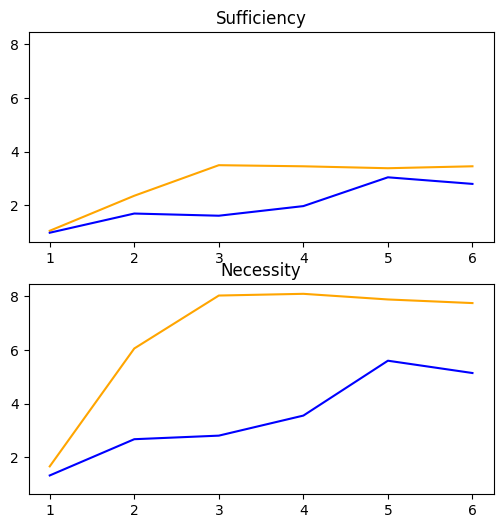

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
x = np.arange(1, len(scores1)+1)
x2 = np.arange(1, len(scores2)+1)

# artists = []
# Pair each element of 'test' with the corresponding element of 'test2'
container1 = ax1.plot(x, [a[0] for a in scores1], color="orange")
container2 = ax2.plot(x, [a[1] for a in scores1], color="orange")
container1 = ax1.plot(x2, [a[0] for a in scores2], color="blue")
container2 = ax2.plot(x2, [a[1] for a in scores2], color="blue")
# artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Sufficiency")
ax2.set_title("Necessity")


# comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()
# comp

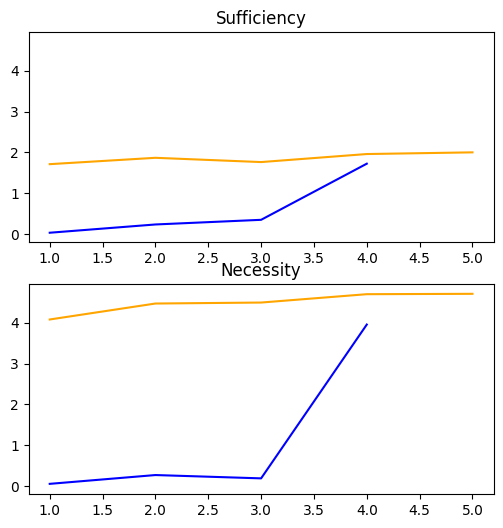

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
x = np.arange(1, len(scores1)+1)
x2 = np.arange(1, len(scores2)+1)

# artists = []
# Pair each element of 'test' with the corresponding element of 'test2'
container1 = ax1.plot(x, [a[0] for a in scores1], color="orange")
container2 = ax2.plot(x, [a[1] for a in scores1], color="orange")
container1 = ax1.plot(x2, [a[0] for a in scores2], color="blue")
container2 = ax2.plot(x2, [a[1] for a in scores2], color="blue")
# artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Sufficiency")
ax2.set_title("Necessity")


# comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()
# comp

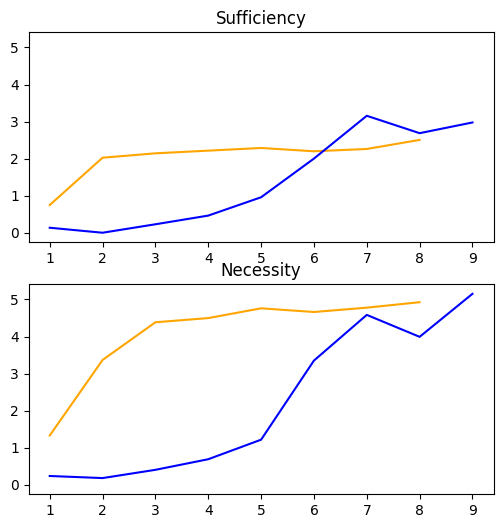

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
x = np.arange(1, len(scores1)+1)
x2 = np.arange(1, len(scores2)+1)

# artists = []
# Pair each element of 'test' with the corresponding element of 'test2'
container1 = ax1.plot(x, [a[0] for a in scores1], color="orange")
container2 = ax2.plot(x, [a[1] for a in scores1], color="orange")
container1 = ax1.plot(x2, [a[0] for a in scores2], color="blue")
container2 = ax2.plot(x2, [a[1] for a in scores2], color="blue")
# artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Sufficiency")
ax2.set_title("Necessity")


# comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()
# comp

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

def compare_plot(scores1, scores2):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
    x = np.arange(1, len(scores1)+1)
    x2 = np.arange(1, len(scores2)+1)

    # artists = []
    # Pair each element of 'test' with the corresponding element of 'test2'
    container1 = ax1.plot(x, [a[0] for a in scores1], color="#FF5733", linestyle='--', marker='o', label="Greedy")
    container2 = ax2.plot(x, [a[1] for a in scores1], color="#FF5733", linestyle='--', marker='o', label="Greedy")
    container1 = ax1.plot(x2, [a[0] for a in scores2], color="#3366FF", linestyle='--', marker='o', label="AlphaDNA")
    container2 = ax2.plot(x2, [a[1] for a in scores2], color="#3366FF", linestyle='--', marker='o', label="AlphaDNA")
    # artists.append(container1 + container2)  # Combine the artists for both subplots in one list

    ax1.set_title("Sufficiency")
    ax2.set_title("Necessity")
    
    ax1.legend()
    # ax2.legend()

    # comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
    plt.show()
# comp

In [76]:
def get_trajectory(seq, act):
    # a = data_module.x_test[seq_num].numpy()
    a = seq
    b = (shuffle_test.dinuc_shuffle(a.copy().transpose())).transpose()
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)

    scores = []
    for i in range(1, len(act)):
        ori, mut = get_swap_greedy(a, b, act[0:i])

        batch = np.array([a, b, ori, mut])
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred2 = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))

        final_score, score_list = get_score(pred2)
        
        score_list = score_list.tolist()
        scores.append(score_list)
    
    return scores

In [71]:
def greedy_search(seq):
    com = []
    for i in range(10):
        _, out1, out2, _, total_score = greedy_search_ori(seq, threshold=0.05, trials=200)
        com.append(out1)
        print(f"{out1} \t {out2}")
    
    common_ind = find_common_elements_with_order(com)
    print(f"The common indices among the 10 are: {common_ind}")

    tile_ranges2 = generate_tile_ranges(seq.shape[1],5,5)
    act = []
    for i in common_ind:
        act.append(tile_ranges2[i])

    print(act)
    return act

In [74]:
def alphadna_search(sequence):
    seqgame = SeqGame(sequence, standard_cnn)


    mcts_config = {
        "puct_coefficient": 2.0,
        "num_simulations": 10000,
        "temperature": 1.5,
        "dirichlet_epsilon": 0.25,
        "dirichlet_noise": 0.03,
        "argmax_tree_policy": False,
        "add_dirichlet_noise": True,
    }

    model = CNN_v1(seqgame.action_size, num_resBlocks=4)
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    mcts = MCTS(model, mcts_config)

    # Get the initial sequence and create the root node
    initial_sequence = seqgame.get_seq()
        
    root_node = Node(
        state=initial_sequence,
        reward=0,
        done=False,
        action=None,
        parent=RootParentNode(env=seqgame),
        mcts=mcts, 
        level=0, 
        tile_ranges_done=[]
    )

    while not root_node.done:  # Loop until the root node indicates the game is done
        # print("Current sequence:", convert_elements(root_node.state[-1,:]))
        valid_moves = root_node.valid_actions
        # print("Valid moves:", [i for i in range(seqgame.action_size) if valid_moves[i] == 1])

        # Perform simulations and select an action using MCTS
        mcts_probs, action, next_node = mcts.compute_action(root_node)
        # print("MCTS probabilities:", mcts_probs)
        # print("Selected action:", action)
        

        if valid_moves[action] == 0:
            print("Invalid action, skipping.")
            continue
        
        # print(root_node.tile_ranges_done)
        if next_node.done:
            print(root_node.tile_ranges_done)
            print(root_node.reward)
            print("Game ended")
            return root_node.tile_ranges_done
        # print(root_node.reward)

        root_node = next_node

    print("Game ended.")


Game ended
[17, 29, 23, 11, 24, 21, 25, 4, 33, 14, 38, 37] 	 3.693936824798584
[17, 29, 23, 11, 24, 21, 4, 25, 15, 38, 34, 48, 13, 18, 28, 37, 36, 19] 	 4.418890476226807
[17, 23, 29, 11, 24, 21, 25, 4, 33, 38, 14, 48, 37, 19, 36, 18, 15, 26, 40] 	 5.331546783447266
[17, 29, 23, 11, 24, 21, 4, 25, 33, 15, 38, 18, 37, 48] 	 3.6377475261688232
[17, 29, 23, 11, 21, 24, 25, 14, 4, 34, 48, 38, 18, 15, 19, 28, 37, 36, 33, 16] 	 4.440568447113037
[17, 23, 29, 24, 11, 21, 25, 4, 15, 34, 48, 38, 18, 37, 13, 36, 16, 28] 	 3.4818501472473145
[17, 23, 29, 24, 11, 21, 25, 4, 14, 34, 38, 48, 18, 15, 37, 19, 36, 28] 	 3.620528221130371
[17, 29, 23, 24, 11, 21, 25, 4, 33, 38, 14, 48, 37, 18, 15, 16] 	 4.254302501678467
[17, 29, 23, 11, 24, 21, 25, 4, 15, 34, 48, 38, 19, 18, 37] 	 4.482094764709473
[17, 23, 24, 11, 21, 29, 4, 25, 14, 33, 38, 37, 48, 19, 36] 	 3.297001838684082
The common indices among the 10 are: [17, 29, 23, 11, 24, 21, 25, 4, 38, 37]
[[85, 90], [145, 150], [115, 120], [55, 60], [120,

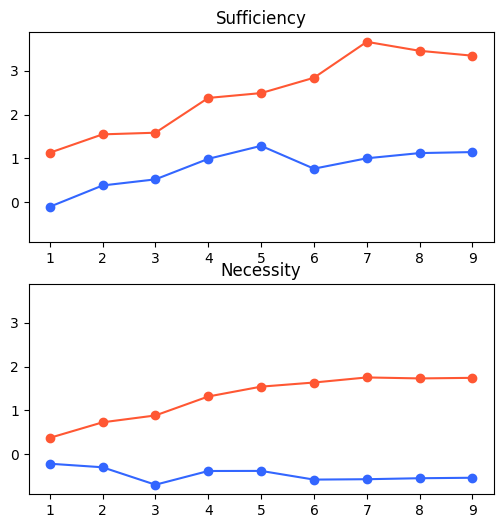

In [77]:
sequence = data_module.x_test[104].numpy()

score1 = get_trajectory(sequence, greedy_search(sequence))
score2 = get_trajectory(sequence, alphadna_search(sequence))

compare_plot(score1, score2)

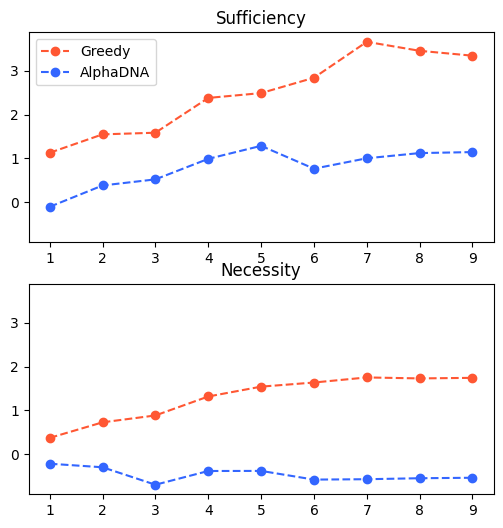

In [81]:
compare_plot(score1, score2)